In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import seaborn as sns
from data_analysis_preparation.utils import (base_volumetric_columns,
                                             get_bounding_box,
                                             get_mci_progression,
                                             get_mean_image_per_diagnosis,
                                             load_adnimerge,
                                             query_images_paths)

### Load data

In [2]:
ADNIMERGE_PATH = r"../DATA/ADNIMERGE.csv"
PREPROCESSED_IMAGE_PATH = r"/mnt/a/ADNI_full_processed"

In [3]:
df_adnimerge = load_adnimerge(ADNIMERGE_PATH)

In [4]:
df_adnimerge = query_images_paths(df_adnimerge, PREPROCESSED_IMAGE_PATH)

Found 4670 images


## Data analysis

Number of rows: 3550
Number of unique subjects: 819
Minimal age: 54.4
Maximal age: 90.9
Age distribution:


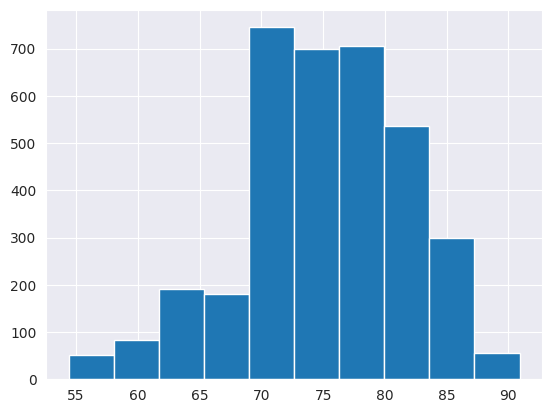

In [5]:
print(f"Number of rows: {len(df_adnimerge)}")
print(f"Number of unique subjects: {len(df_adnimerge.groupby('PTID'))}")
print(f"Minimal age: {df_adnimerge['AGE'].min()}")
print(f"Maximal age: {df_adnimerge['AGE'].max()}")
print(f"Age distribution:")
age_hist = df_adnimerge['AGE'].hist()
fig = age_hist.get_figure()
fig.savefig("ADNI_age_histogram")

In [6]:
print(f"Gender distribution per scan:")
print(df_adnimerge['PTGENDER'].value_counts())
print(f"Genders distribution per subject:")
print(df_adnimerge[["PTID", "PTGENDER"]].drop_duplicates()['PTGENDER'].value_counts())

Gender distribution per scan:
PTGENDER
Male      2108
Female    1442
Name: count, dtype: int64
Genders distribution per subject:
PTGENDER
Male      477
Female    342
Name: count, dtype: int64


Diagnosis distribution per subject:
DX
MCI    416
AD     356
CN     246
Name: count, dtype: int64


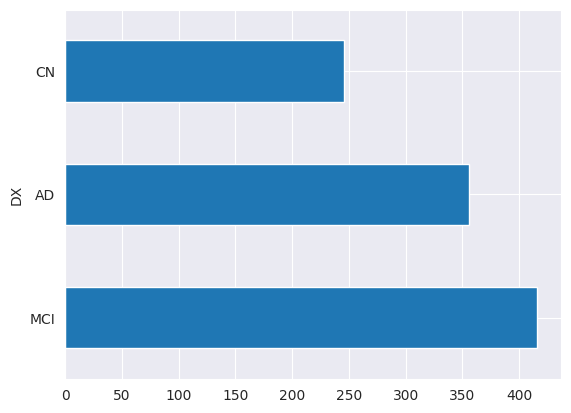

In [7]:
print(f"Diagnosis distribution per subject:")
print(df_adnimerge[["PTID", "DX"]].drop_duplicates()["DX"].value_counts())
diag_plot = df_adnimerge[["PTID", "DX"]].drop_duplicates()["DX"].value_counts().plot.barh()
fig = diag_plot.get_figure()
fig.savefig("ADNI_diagnosis_persubject_plot")

Diagnosis distribution per scan:
DX
MCI    1482
CN     1060
AD     1008
Name: count, dtype: int64


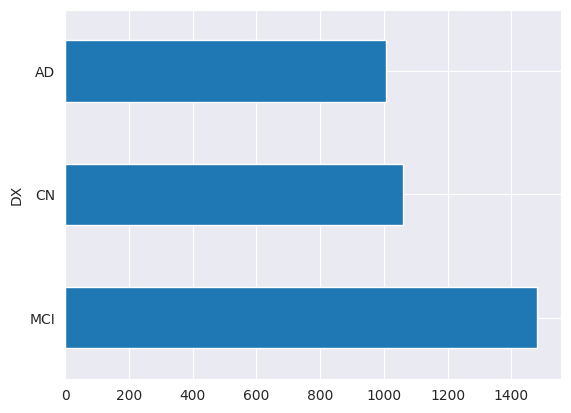

In [8]:
print("Diagnosis distribution per scan:")
print(df_adnimerge["DX"].value_counts())
diag_plot = df_adnimerge["DX"].value_counts().plot.barh()
fig = diag_plot.get_figure()
fig.savefig("ADNI_diagnosis_perscan_plot")

Diagnosis distribution per gender on baseline visit:


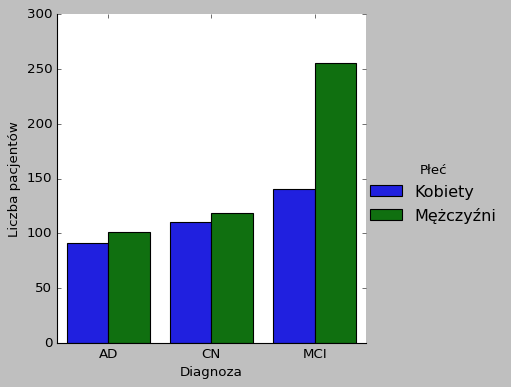

In [9]:
print("Diagnosis distribution per gender on baseline visit:")
df_plot = df_adnimerge[df_adnimerge['VISCODE'] == "bl"]
plot_data = df_plot[["DX", "PTGENDER"]].groupby(["DX", "PTGENDER"]).size().reset_index(name="count")
#plot_data
plot_data.columns = ["Diagnoza", "Płeć", "Liczba pacjentów"]
plot_data["Płeć"] = plot_data["Płeć"].map({"Male": "Mężczyźni", "Female": "Kobiety"})
plt.style.use('classic')
sns.catplot(x="Diagnoza", y="Liczba pacjentów", hue="Płeć", data=plot_data, kind="bar").savefig("ADNI_diagnoza_plec")

### Subjects age distribution

In [10]:
df_patients = df_adnimerge[["PTID", "PTGENDER", "AGE", "DX"]].groupby("PTID").agg({"PTGENDER": "first", "AGE": "mean", "DX": "first"})
df_patients['AGE'] = df_patients['AGE'].astype(int)

In [11]:
pd.DataFrame({"age_AD": df_patients[df_patients["DX"] == "AD"]["AGE"].describe().round(2),
 "age_AD_female": df_patients[(df_patients["DX"] == "AD") & (df_patients['PTGENDER'] == "Female")]["AGE"].describe().round(2),
 "age_AD_male": df_patients[(df_patients["DX"] == "AD") & (df_patients['PTGENDER'] == "Male")]["AGE"].describe().round(2)
 })


,age_AD,age_AD_female,age_AD_male
count,196.00,91.00,105.00
mean,74.86,74.29,75.36
std,7.44,7.66,7.24
min,55.00,55.00,56.00
25%,70.00,70.00,70.00
50%,75.50,75.00,76.00
75%,80.25,80.00,81.00
max,90.00,90.00,87.00


In [12]:
pd.DataFrame({"age_MCI": df_patients[df_patients["DX"] == "MCI"]["AGE"].describe().round(2),
 "age_MCI_female": df_patients[(df_patients["DX"] == "MCI") & (df_patients['PTGENDER'] == "Female")]["AGE"].describe().round(2),
 "age_MCI_male": df_patients[(df_patients["DX"] == "MCI") & (df_patients['PTGENDER'] == "Male")]["AGE"].describe().round(2)
 })

,age_MCI,age_MCI_female,age_MCI_male
count,391.00,139.00,252.00
mean,74.25,73.23,74.81
std,7.39,7.44,7.31
min,54.00,55.00,54.00
25%,70.00,69.00,70.00
50%,75.00,74.00,75.00
75%,80.00,79.50,80.00
max,88.00,86.00,88.00


In [13]:
pd.DataFrame({"age_CN": df_patients[df_patients["DX"] == "CN"]["AGE"].describe().round(2),
              "age_CN_female": df_patients[(df_patients["DX"] == "CN") & (df_patients['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_CN_male": df_patients[(df_patients["DX"] == "CN") & (df_patients['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_CN,age_CN_female,age_CN_male
count,232.00,112.00,120.00
mean,75.48,75.61,75.37
std,5.13,4.83,5.41
min,59.00,62.00,59.00
25%,72.00,72.00,72.00
50%,75.00,75.00,75.00
75%,78.00,78.00,79.00
max,89.00,89.00,89.00


In [14]:
df_mci_progression = get_mci_progression(df_adnimerge)
pd.DataFrame({"age_p-MCI": df_mci_progression[df_mci_progression["DX"] == "p-MCI"]["AGE"].describe().round(2),
              "age_p-MCI_female": df_mci_progression[(df_mci_progression["DX"] == "p-MCI") & (df_mci_progression['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_p-MCI_male": df_mci_progression[(df_mci_progression["DX"] == "p-MCI") & (df_mci_progression['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_p-MCI,age_p-MCI_female,age_p-MCI_male
count,450.00,166.00,284.00
mean,74.57,73.24,75.35
std,6.99,7.10,6.82
min,55.20,55.20,57.70
25%,69.90,69.10,71.20
50%,75.30,72.50,76.30
75%,80.15,79.40,80.40
max,88.30,84.40,88.30


In [15]:
df_mci_progression = get_mci_progression(df_adnimerge)
pd.DataFrame({"age_p-MCI": df_mci_progression[df_mci_progression["DX"] == "np-MCI"]["AGE"].describe().round(2),
              "age_p-MCI_female": df_mci_progression[(df_mci_progression["DX"] == "np-MCI") & (df_mci_progression['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_p-MCI_male": df_mci_progression[(df_mci_progression["DX"] == "np-MCI") & (df_mci_progression['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_p-MCI,age_p-MCI_female,age_p-MCI_male
count,1008.00,336.00,672.00
mean,74.96,73.76,75.57
std,7.32,7.75,7.02
min,54.40,55.10,54.40
25%,70.80,68.78,71.40
50%,75.10,75.30,75.10
75%,80.70,80.40,81.50
max,89.30,86.20,89.30


### Anatomical structures volumes per diagnosis


In [16]:
df_patients = df_adnimerge[df_adnimerge["VISCODE"] == "bl"]
anatomical_structures_columns = ["PTID", "PTGENDER", "DX", "MMSE"] + base_volumetric_columns
df_patients = df_patients[anatomical_structures_columns]

In [17]:
print("CN")
df_patients[df_patients["DX"] == "CN"].describe().round(2).loc[["min", "max", "std"]]

CN


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,25.0,5834.00,5198.00,746249.00,1870.00,11541.00,11546.00,1116280.00
max,30.0,118875.00,10769.00,1231190.00,5731.00,24788.00,27936.00,1984660.00
std,1.0,19762.48,905.06,100534.92,678.09,2232.98,2845.94,157759.93


In [18]:
print("MCI")
df_patients[df_patients["DX"] == "MCI"].describe().round(2).loc[["min", "max", "std"]]

MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,23.00,7801.00,3281.0,669364.00,1558.00,10237.00,10472.00,1175130.00
max,30.00,145115.00,9433.0,1364230.00,5660.00,22690.00,26705.00,2110290.00
std,1.78,23673.46,1075.0,110700.73,753.82,2382.68,3002.39,168992.51


In [19]:
print("AD")
df_patients[df_patients["DX"] == "AD"].describe().round(2).loc[["min", "max", "std"]]

AD


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,18.00,9166.00,3091.00,727478.00,1426.00,8991.00,9375.00,1214530.00
max,27.00,138037.00,9572.00,1364690.00,5430.00,22638.00,28103.00,2057400.00
std,2.04,25884.69,1056.72,108164.38,690.76,2598.34,3071.29,184354.86


In [20]:
print("p-MCI")
df_mci_progression = df_mci_progression[df_mci_progression["VISCODE"] == "bl"][anatomical_structures_columns]
df_mci_progression[df_mci_progression["DX"] == "p-MCI"].describe().round(2).loc[["min", "max", "std"]]

p-MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,23.0,10739.00,3281.00,669364.00,1558.00,10467.00,10472.00,1175130.0
max,30.0,145115.00,8811.00,1350180.00,4886.00,22299.00,26379.00,2110290.0
std,1.7,22536.67,1057.71,116484.17,729.37,2515.54,2977.73,175856.7


In [21]:
print("np-MCI")
df_mci_progression[df_mci_progression["DX"] == "np-MCI"].describe().round(2).loc[["min", "max", "std"]]

np-MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,24.00,7801.00,4404.0,764118.00,1760.00,10237.00,10850.00,1191650.00
max,30.00,144303.00,9433.0,1364230.00,5660.00,22690.00,26705.00,2040440.00
std,1.78,23889.87,1007.7,105557.73,716.86,2224.47,2833.23,163458.23


## Analysis of preprocessed imaging data

In [22]:
ad_mean, mci_mean, cn_mean = get_mean_image_per_diagnosis(df_adnimerge)

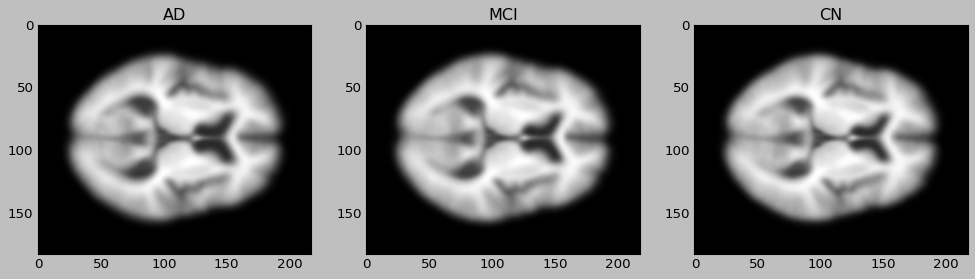

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ad_mean, cmap='gray')
axes[0].set_title('AD')
axes[1].imshow(mci_mean, cmap='gray')
axes[1].set_title('MCI')
axes[2].imshow(cn_mean, cmap='gray')
axes[2].set_title('CN')
plt.savefig('ADNI_mean_scans.png')

In [24]:
df_adnimerge[["xmin", "xmax", "ymin", "ymax", "zmin", "zmax", "width", "height", "depth", "min_val", "max_val"]] = df_adnimerge.apply(lambda row: get_bounding_box(nib.load(row['path']).get_fdata()), axis=1, result_type="expand")
df_adnimerge[["xmin", "xmax", "ymin", "ymax", "zmin", "zmax", "width", "height", "depth", "min_val", "max_val"]].describe()

,xmin,xmax,ymin,ymax,zmin,zmax,width,height,depth,min_val,max_val
count,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.000000,3550.0,3550.0
mean,20.437465,158.021408,22.713239,194.386479,14.455211,146.740563,137.583944,171.673239,132.285352,0.0,255.0
std,2.934603,2.978195,3.985112,3.738258,3.517391,2.847790,5.727947,7.271628,5.541054,0.0,0.0
min,9.000000,149.000000,7.000000,179.000000,0.000000,138.000000,121.000000,150.000000,116.000000,0.0,255.0
25%,19.000000,156.000000,20.000000,192.000000,12.000000,145.000000,133.250000,167.000000,129.000000,0.0,255.0
50%,20.000000,158.000000,22.000000,194.000000,14.000000,147.000000,138.000000,172.000000,132.000000,0.0,255.0
75%,22.000000,160.000000,25.000000,197.000000,17.000000,148.000000,141.000000,177.000000,136.000000,0.0,255.0
max,30.000000,170.000000,37.000000,207.000000,30.000000,157.000000,161.000000,199.000000,155.000000,0.0,255.0
